# Import
We need to use the following libraries for this example:
* `LoopStructural`
* `numpy`
* `lavavu`, on headless linux environments use `lavavu-osmesa`
* `pandas`
* `matplotlib`

If you are using a google colab environment or do not have these libraries already installed uncomment the following line. 

In [1]:
#!pip install matplotlib lavavu-osmesa LoopStructural

In [2]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.utils.helper import strike_dip_vector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams

In [3]:
# define the bounding box for the model
boundary_points = np.zeros((2,3))
boundary_points[0,0] = -11
boundary_points[0,1] = -11
boundary_points[0,2] = -6
boundary_points[1,0] = 11
boundary_points[1,1] = 11
boundary_points[1,2] = 2

In [4]:
# generate an input dataset specifying the vector components and locations of observations. 
# note that two faults are defined, f1 and f2
data = pd.DataFrame(columns=['X','Y','Z','val','nx','ny','nz','feature_name'],dtype=float)
data.loc[len(data),['X','Y','Z','val','feature_name']] = [0.,-10.,-1.,0.,'f1']
data.loc[len(data),['X','Y','Z','val','feature_name']] = [0.,-5.,-2.,0.,'f1']
data.loc[len(data),['X','Y','Z','val','feature_name']] = [-5.,10.,0.,0.,'f1']
data.loc[len(data),['X','Y','Z','val','feature_name']] = [-5.,5.,0.,0.,'f1']
v1 = strike_dip_vector([0.],[70.])[0]
v2 = strike_dip_vector([20.],[50.])[0]
v3 = strike_dip_vector([10.],[50.])[0]
data.loc[len(data),['X','Y','Z','nx','ny','nz','feature_name']] = [0.,-10.,0.,v1[0],v1[1],v1[2],'f1']
data.loc[len(data),['X','Y','Z','nx','ny','nz','feature_name']] = [0.,-5.,0.,v1[0],v1[1],v1[2],'f1']
data.loc[len(data),['X','Y','Z','nx','ny','nz','feature_name']] = [0.,-9.,-4.,v1[0],v1[1],v1[2],'f1']
data.loc[len(data),['X','Y','Z','nx','ny','nz','feature_name']] = [0.,-6.,-2.,v1[0],v1[1],v1[2],'f1']
data.loc[len(data),['X','Y','Z','nx','ny','nz','feature_name']] = [-5.,10.,0.,v2[0],v2[1],v2[2],'f1']
data.loc[len(data),['X','Y','Z','nx','ny','nz','feature_name']] = [-5.,5.,0.,v3[0],v3[1],v3[2],'f1']

data.loc[len(data),['X','Y','Z','val','feature_name']] = [0.,-10.,-1.,0.,'f2']
data.loc[len(data),['X','Y','Z','val','feature_name']] = [0.,-5.,-2.,0.,'f2']
data.loc[len(data),['X','Y','Z','val','feature_name']] = [1.,10.,0.,0.,'f2']
data.loc[len(data),['X','Y','Z','val','feature_name']] = [1.,10.,0.,0.,'f2']

data.loc[len(data),['X','Y','Z','nx','ny','nz','feature_name']] = [0.,-10.,0.,v1[0],v1[1],v1[2],'f2']
data.loc[len(data),['X','Y','Z','nx','ny','nz','feature_name']] = [0.,-5.,0.,v1[0],v1[1],v1[2],'f2']
data.loc[len(data),['X','Y','Z','nx','ny','nz','feature_name']] = [0.,-9.,-4.,v1[0],v1[1],v1[2],'f2']
data.loc[len(data),['X','Y','Z','nx','ny','nz','feature_name']] = [0.,-6.,-2.,v1[0],v1[1],v1[2],'f2']


We create a LoopStructural **GeologicalModel** using the origin and maximum from the bounding box. This defines the area that we are trying to model. The dataset that was generated in the previous cell is associated with the model - when it is associated it is transformed into the model coordinate system (origin of (0,0,0))

In this example both faults are modelled independently using the finite difference interpolator `FDI`

In [5]:
model = GeologicalModel(boundary_points[0,:],boundary_points[1,:])
model.set_model_data(data)
f1 = model.create_and_add_fault('f1',0,nelements=1e4,interpolatortype='FDI',regularisation=[0.2,0.2,0.2])
f2 = model.create_and_add_fault('f2',0,nelements=1e4,interpolatortype='FDI',regularisation=[0.2,0.2,0.2])


2021-08-18 03:22:57,744 ~ LoopStructural.modelling.core.geological_model ~ WARNING    ~ Depreciated method. Model data can now be set using the data attribute
2021-08-18 03:22:57,744 ~ LoopStructural.modelling.core.geological_model ~ WARNING    ~ Depreciated method. Model data can now be set using the data attribute
2021-08-18 03:22:57,786 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for structural frame coordinate 1, 
Add some more and try again.
2021-08-18 03:22:57,786 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for structural frame coordinate 1, 
Add some more and try again.
2021-08-18 03:22:57,787 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for fold frame coordinate 1, 
Add some more and try again.
2021-08-18 03:22:57,787 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints f

In this example we define a region where the surfaces should share the same value, this is the `splayregion`. In this case we define this region as anywhere where the y coordinate is < 0.

The splay region is used to set the splay fault f2, to be equal to the geometry of f1 in this location. Note that when modelling splay faults this uses the lagrange multipliers and modifies the interpolation matrix. For this reason, it is not possible to use the optimised `pyamg` solver.  

In [6]:
model2 = GeologicalModel(boundary_points[0,:],boundary_points[1,:])
model2.set_model_data(data)
splay_region = lambda pos : model2.rescale(pos)[:,1] < -3
model2.create_and_add_fault('f1',0,nelements=1e4,buffer=0.51,interpolatortype='FDI',regularisation=[0.1,0.1,0.1])
model2.create_and_add_fault('f2',0,nelements=2e4,
                            splay=model2.features[0],
                            splayregion=splay_region,
                            interpolatortype='FDI',
#                             damp=True
#                             maxiter=1000,
                            regularisation=[0.1,0.1,0.1]
                           )
model2.update()

2021-08-18 03:22:57,829 ~ LoopStructural.modelling.core.geological_model ~ WARNING    ~ Depreciated method. Model data can now be set using the data attribute
2021-08-18 03:22:57,829 ~ LoopStructural.modelling.core.geological_model ~ WARNING    ~ Depreciated method. Model data can now be set using the data attribute
2021-08-18 03:22:57,863 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for structural frame coordinate 1, 
Add some more and try again.
2021-08-18 03:22:57,863 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for structural frame coordinate 1, 
Add some more and try again.
2021-08-18 03:22:57,865 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for fold frame coordinate 1, 
Add some more and try again.
2021-08-18 03:22:57,865 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints f

0it [00:00, ?it/s]

2021-08-18 03:23:23,224 ~ LoopStructural.modelling.features.geological_feature_builder ~ ERROR      ~ Not enough constraints for scalar field add more
2021-08-18 03:23:23,224 ~ LoopStructural.modelling.features.geological_feature_builder ~ ERROR      ~ Not enough constraints for scalar field add more
2021-08-18 03:23:23,791 ~ LoopStructural.interpolators.discrete_interpolator ~ WARNING    ~ No solution, f1_1 scalar field 0. Add more data.
2021-08-18 03:23:23,791 ~ LoopStructural.interpolators.discrete_interpolator ~ WARNING    ~ No solution, f1_1 scalar field 0. Add more data.
2021-08-18 03:23:23,798 ~ LoopStructural.modelling.features.geological_feature_builder ~ ERROR      ~ Not enough constraints for scalar field add more
2021-08-18 03:23:23,798 ~ LoopStructural.modelling.features.geological_feature_builder ~ ERROR      ~ Not enough constraints for scalar field add more
2021-08-18 03:23:24,361 ~ LoopStructural.interpolators.discrete_interpolator ~ WARNING    ~ No solution, f1_2 scal

# Visualisation
The visualisation module of LoopStructural can be used to draw isosurfaces of the fault. Where the feature can be retrieved from the model using the `[]` accessor and the feature name.

In [7]:
from LoopStructural.modelling.features import LambdaGeologicalFeature
region = LambdaGeologicalFeature(splay_region)
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(model2['f1'],isovalue=0,name='model2_f1',colour='blue')
viewer.add_isosurface(model2['f2'],isovalue=0,name='model2_f2')
viewer.add_data(model2['f1'][0])
# viewer.add_scalar_field(region)
# viewer.add_data(model2['f2'][0])
viewer.interactive()

In [8]:
#export the viewer to an interactive html file
viewer.export_to_webgl('splay_fault_constrained')

In [9]:
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(model['f1'],isovalue=0,name='model_f1',colour='blue')
viewer.add_isosurface(model['f2'],isovalue=0,name='model_f2')
viewer.add_data(model['f1'][0])
viewer.add_data(model['f2'][0])
viewer.interactive()

In [10]:
viewer.export_to_webgl('splay_fault_unconstrained')

In [11]:
viewer.clear()

# Code for creating paper figure
The following code extracts images and saves the rbga array to a list and this is then plotted using matplotlib.

In [12]:
ims = []
viewer.border = 0
viewer.add_isosurface(model2['f1'],isovalue=0,name='model2_f1',colour='blue')
viewer.add_isosurface(model2['f2'],isovalue=0,name='model2_f2')
viewer.rotation = [-67.93016815185547, -9.925044059753418, -2.6390838623046875]
ims.append(viewer.image_array())
viewer.rotation = [-67.93016815185547, -9.925044059753418, -2.6390838623046875]
ims.append(viewer.image_array())
viewer.clear()

viewer.add_isosurface(model['f1'],isovalue=0,name='model2_f1',colour='blue')
viewer.add_isosurface(model['f2'],isovalue=0,name='model2_f2')
viewer.rotation = [-67.93016815185547, -9.925044059753418, -2.6390838623046875]
ims.append(viewer.image_array())
viewer.rotation = [-67.93016815185547, -9.925044059753418, -2.6390838623046875]
ims.append(viewer.image_array())
viewer.clear()

[]

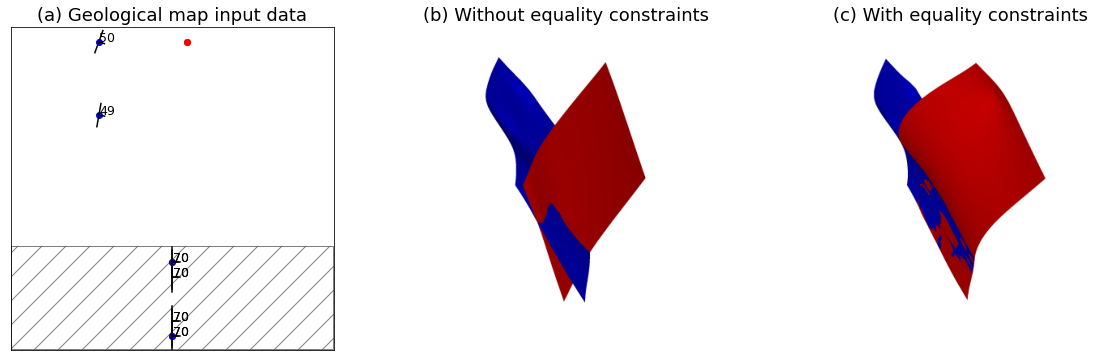

In [19]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
rcParams['font.size'] = 15

fig  = plt.figure(figsize=(20,7.5))
gs = GridSpec(5, 3,)# width_ratios=[1,1.2,1.2],height_ratios=[1])
ax1 = fig.add_subplot(gs[1:,0])
ax2 = fig.add_subplot(gs[1:,1])
ax3 = fig.add_subplot(gs[1:,2])
from LoopStructural.visualisation import MapView
mapview = MapView(model,ax=ax1)
mapview.add_data(model.features[1][0],point_colour='red')
mapview.add_data(model.features[0][0],point_colour='blue',symb_scale=0.8)
# mapview.add_contour(region,0,linestyles=['dashed'],colors=['black'],)
# mapview.xmin= -0.1
# mapview.xmax= 1.1
# mapview.ymin= -0.1
# mapview.ymax= 1.1

patch = Rectangle(xy=(-11,-10.9),width=21.9,height=7,hatch='/',fill=False,alpha=0.5)
ax1.add_patch(patch)
ax1.set_title('(a) Geological map input data')
ax2.set_title('(b) Without equality constraints')
ax2.imshow(ims[3][50:450,200:500])
ax3.set_title('(c) With equality constraints')
ax3.imshow(ims[1][50:450,200:500])

ax2.axis('off')
ax3.axis('off')
# ax1.axis('off')
ax1.set_xticks([])
ax1.set_yticks([])
# plt.tight_layout()

In [14]:
x = [-11,11,11,-11]
y = 

SyntaxError: invalid syntax (<ipython-input-14-780870561ab4>, line 2)

In [ ]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = -11
boundary_points[0,1] = -11
boundary_points[0,2] = -6
boundary_points[1,0] = 11
boundary_points[1,1] = 11
boundary_points[1,2] = 2